# **Problem 4: Offline signature feature extraction for signature recognitions**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# A.

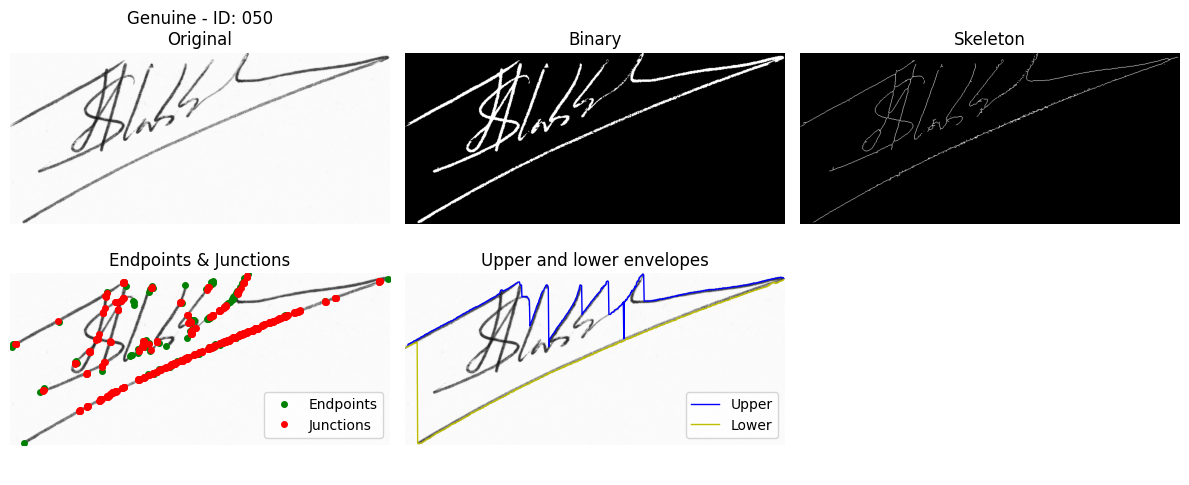

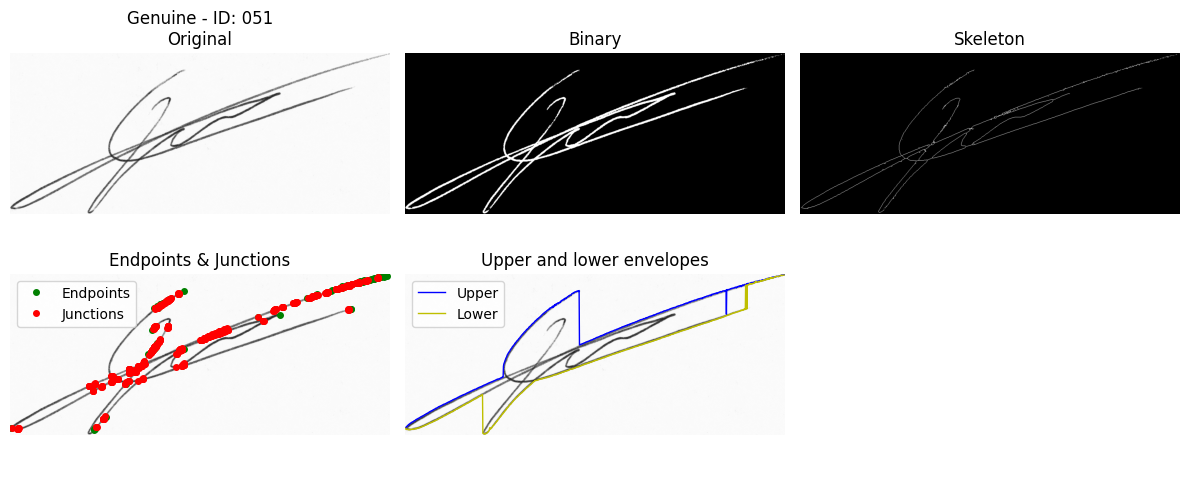

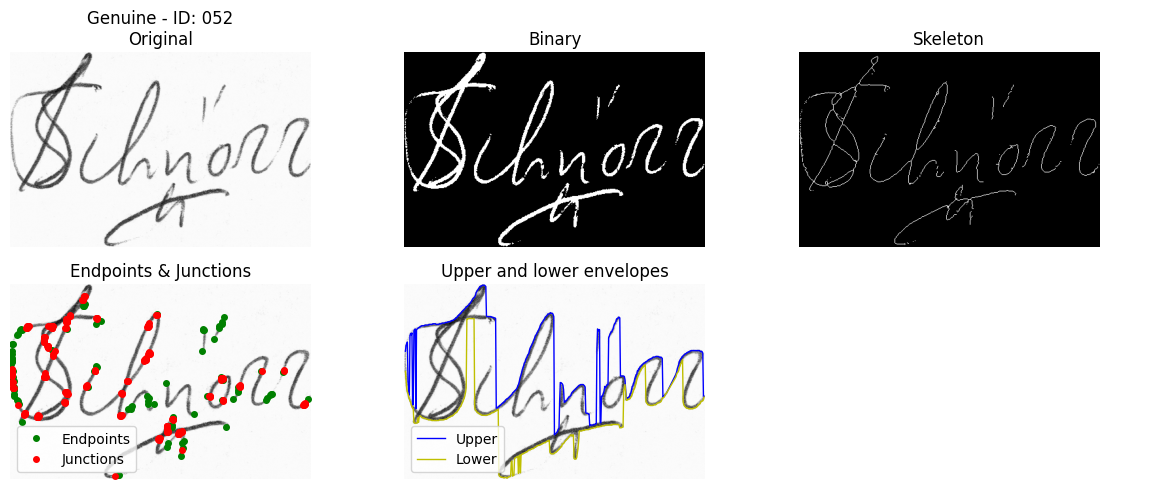

Feature extraction completed successfully.


In [2]:
BASE_SIGNATURES_PATH = 'signatures'

def process_signatures(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"[Error] Cannot read image: {image_path}")
        return None

    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Generate skeleton from binary image
    skeleton = skeletonize(binary_image // 255)

    # Detect endpoints and junction points based on 8-neighbor
    endpoints, junctions = [], []
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 (0, -1),           (0, 1),
                 (1, -1),  (1, 0),  (1, 1)]

    for r in range(1, skeleton.shape[0] - 1):
        for c in range(1, skeleton.shape[1] - 1):
            if skeleton[r, c]:
                count = sum(skeleton[r + dr, c + dc] for dr, dc in neighbors)
                if count == 1:
                    endpoints.append((r, c))
                elif count >= 3:
                    junctions.append((r, c))

    # Extract upper and lower envelope
    upper_env, lower_env = [], []
    for c in range(skeleton.shape[1]):
        rows = np.where(binary_image[:, c] == 255)[0]
        if rows.size:
            upper_env.append((c, rows.min()))
            lower_env.append((c, rows.max()))

    # Return all extracted features
    return {
        'original_image': image,
        'binary_image': binary_image,
        'skeleton': skeleton,
        'endpoints': endpoints,
        'junction_points': junctions,
        'upper_envelope': upper_env,
        'lower_envelope': lower_env
    }

def plot_signature_features(image, binary, skeleton, endpoints, junctions, upper, lower, title=""):
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    axes[0, 0].imshow(image, cmap='gray')   # Original grayscale image
    axes[0, 0].set_title(f'{title}\nOriginal')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(binary, cmap='gray')   # Binary image
    axes[0, 1].set_title('Binary')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(skeleton, cmap='gray')   # Skeleton image
    axes[0, 2].set_title('Skeleton')
    axes[0, 2].axis('off')

    # Plot endpoints (green) and junctions (red) on original image
    axes[1, 0].imshow(image, cmap='gray')
    if endpoints:
        ep_y, ep_x = zip(*endpoints)
        axes[1, 0].plot(ep_x, ep_y, 'go', label='Endpoints', markersize=4)
    if junctions:
        jp_y, jp_x = zip(*junctions)
        axes[1, 0].plot(jp_x, jp_y, 'ro', label='Junctions', markersize=4)
    axes[1, 0].set_title('Endpoints & Junctions')
    axes[1, 0].axis('off')
    axes[1, 0].legend()

    # Plot upper (blue) and lower (yellow) envelope curves
    axes[1, 1].imshow(image, cmap='gray')
    if upper:
        x, y = zip(*upper)
        axes[1, 1].plot(x, y, 'b-', label='Upper', linewidth=1)
    if lower:
        x, y = zip(*lower)
        axes[1, 1].plot(x, y, 'y-', label='Lower', linewidth=1)
    axes[1, 1].set_title('Upper and lower envelopes')
    axes[1, 1].axis('off')
    axes[1, 1].legend()

    axes[1, 2].axis('off')
    plt.tight_layout()
    plt.show()

# Selected sample images for 50, 51 and 52
if __name__ == '__main__':
    all_signature_features = {}
    sample_images = [
        os.path.join(BASE_SIGNATURES_PATH, '050', '01_050.png'),
        os.path.join(BASE_SIGNATURES_PATH, '051', '01_051.png'),
        os.path.join(BASE_SIGNATURES_PATH, '052', '01_052.png')
    ]

    if not os.path.exists(BASE_SIGNATURES_PATH):
        print(f"Error! Folder '{BASE_SIGNATURES_PATH}' not found.")
    else:
        # Loop through all folders 
        for folder in os.listdir(BASE_SIGNATURES_PATH):
            path = os.path.join(BASE_SIGNATURES_PATH, folder)
            if not os.path.isdir(path):
                continue

            pid = folder.replace('_forg', '')
            is_genuine = '_forg' not in folder
            # Initialize feature lists for this person
            all_signature_features.setdefault(pid, {'genuine': [], 'forged': []})

            # Process each png file in the folder
            for fname in os.listdir(path):
                if not fname.lower().endswith('.png'):
                    continue
                fpath = os.path.join(path, fname)
                features = process_signatures(fpath)
                if features:
                    features['filename'] = fname
                    key = 'genuine' if is_genuine else 'forged'
                    all_signature_features[pid][key].append(features)

                    if fpath in sample_images:
                        plot_signature_features(
                            features['original_image'], features['binary_image'], features['skeleton'],
                            features['endpoints'], features['junction_points'],
                            features['upper_envelope'], features['lower_envelope'],
                            title=f"{'Genuine' if is_genuine else 'Forged'} - ID: {pid}"
                        )

    print("Feature extraction completed successfully.")

In [3]:
# Convert skeleton image to list of (x, y) coordinates
def skeleton_to_coords(skeleton):
    return np.column_stack(np.where(skeleton))

# Compute average Hausdorff distance to reference templates
def average_hausdorff_distance(skeleton, template_skeletons):
    distances = []
    A = skeleton_to_coords(skeleton)
    for template in template_skeletons:
        B = skeleton_to_coords(template)
        forward = directed_hausdorff(A, B)[0]
        backward = directed_hausdorff(B, A)[0]
        distances.append(max(forward, backward))
    return np.mean(distances)

HAUSDORFF_THRESHOLD = 100.0   # Classification threshold 

print("\nSignature Classification Results:")

for person_id, data in all_signature_features.items():
    genuine = data['genuine']
    forged = data['forged']

    if len(genuine) < 5:
        print(f"Skipped {person_id}: not enough genuine samples.")
        continue

    # Use first 5 genuine skeletons as reference set
    reference_templates = [f['skeleton'] for f in genuine[:5]]

    # Test remaining genuine signatures
    for g in genuine[5:]:
        dist = average_hausdorff_distance(g['skeleton'], reference_templates)
        predicted = "GENUINE" if dist <= HAUSDORFF_THRESHOLD else "FORGED (WRONG)"
        print(f"ID: {person_id} | File: {g['filename']} | Distance: {dist:.2f} → Predicted: {predicted}")

    # Test forged signatures
    for f in forged:
        dist = average_hausdorff_distance(f['skeleton'], reference_templates)
        predicted = "FORGED" if dist > HAUSDORFF_THRESHOLD else "GENUINE (WRONG)"
        print(f"ID: {person_id} | File: {f['filename']} | Distance: {dist:.2f} → Predicted: {predicted}")


Signature Classification Results:
ID: 050 | File: 06_050.png | Distance: 67.07 → Predicted: GENUINE
ID: 050 | File: 07_050.png | Distance: 79.63 → Predicted: GENUINE
ID: 050 | File: 08_050.png | Distance: 76.00 → Predicted: GENUINE
ID: 050 | File: 09_050.png | Distance: 63.74 → Predicted: GENUINE
ID: 050 | File: 10_050.png | Distance: 95.56 → Predicted: GENUINE
ID: 050 | File: 11_050.png | Distance: 72.20 → Predicted: GENUINE
ID: 050 | File: 12_050.png | Distance: 120.69 → Predicted: FORGED (WRONG)
ID: 050 | File: 01_0125050.PNG | Distance: 123.75 → Predicted: FORGED
ID: 050 | File: 01_0126050.PNG | Distance: 88.33 → Predicted: GENUINE (WRONG)
ID: 050 | File: 01_0204050.PNG | Distance: 272.25 → Predicted: FORGED
ID: 050 | File: 02_0125050.PNG | Distance: 157.13 → Predicted: FORGED
ID: 050 | File: 02_0126050.PNG | Distance: 105.21 → Predicted: FORGED
ID: 050 | File: 02_0204050.PNG | Distance: 127.75 → Predicted: FORGED
ID: 050 | File: 03_0125050.PNG | Distance: 120.58 → Predicted: FORG


Evaluation Metrics:
Accuracy: 0.79
Recall: 0.62
F1-score: 0.68


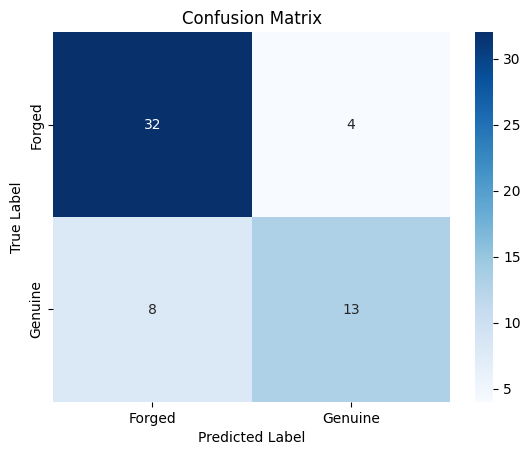

In [ ]:
y_true = []
y_pred = []
all_distances = []

for person_id, data in all_signature_features.items():
    genuine_signatures = data['genuine']
    forged_signatures = data['forged']

    if len(genuine_signatures) < 6:
        continue 

    reference_templates = [f['skeleton'] for f in genuine_signatures[:5]]

    # Evaluate remaining genuine signatures
    for g in genuine_signatures[5:]:
        dist = average_hausdorff_distance(g['skeleton'], reference_templates)
        y_true.append(1)  
        y_pred.append(1 if dist <= HAUSDORFF_THRESHOLD else 0)
        all_distances.append((dist, 'genuine'))

    # Evaluate all forged signatures
    for f in forged_signatures:
        dist = average_hausdorff_distance(f['skeleton'], reference_templates)
        y_true.append(0)  
        y_pred.append(1 if dist <= HAUSDORFF_THRESHOLD else 0)
        all_distances.append((dist, 'forged'))

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Genuine'], yticklabels=['Forged', 'Genuine'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()